In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os

import pandas as pd
import json
import random

from subword_prompt_templates.MultiChoicePrompts import MultiChoicePrompts
from subword_prompt_templates.ClassificationPrompts import ClassificationPrompts

from utils import helpers

from openai import OpenAI

In [5]:
models = ['allenai/OLMo-7B-Instruct', 'meta-llama/Llama-3-8b-chat-hf', 'MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1']
prompts = ['zero_shot', 'one_shot', 'few_shot', 'CoT-one', 'CoT-few', 'decomposite']
dataset = pd.read_csv(r"datasets\dataset_for_evaluation.csv", index_col=0)

TOGETHER_API_KEY = os.environ.get("TOGETHER_API_KEY")
client = OpenAI(api_key=TOGETHER_API_KEY, base_url='https://api.together.xyz/v1')

random.seed(42)

In [4]:
results = []
mcp = MultiChoicePrompts()
ynp = ClassificationPrompts()
for model in models:
    for prompt_type in prompts:
        if '-' in prompt_type: # for CoT
            prompt_technique, shot = prompt_type.split('-')
            kwargs = {'shot': shot}
        else:
            prompt_technique = prompt_type
            kwargs = {}
        for row in dataset.itertuples():
            wrong_choices = json.loads(row.Mulitple_Options.replace(" ", ", ").replace("'", '"'))
            correct_choice = row.Word
            choices = wrong_choices + [correct_choice]
            random.shuffle(choices)
            correct_choice_letter = chr(choices.index(correct_choice) + 65)
            multi_question = mcp.generate(prompt_technique, row.Category, *choices, **kwargs)
            yes_question = ynp.generate(prompt_technique, row.Category, row.Word, **kwargs)
            no_question = ynp.generate(prompt_technique, row.Category, random.choice(wrong_choices), **kwargs)
            multi_answer = helpers.generate_llm_response(client, multi_question, model)
            yes_answer = helpers.generate_llm_response(client, yes_question, model)
            no_answer = helpers.generate_llm_response(client, no_question, model)
            multi_match = helpers.match_answer(multi_answer)
            yes_match = helpers.match_answer(yes_answer)
            no_match = helpers.match_answer(no_answer)
            multi_eval = helpers.evaluate_response(multi_answer, correct_choice_letter)
            yes_eval = helpers.evaluate_response(yes_answer, "Yes")
            no_eval = helpers.evaluate_response(no_answer, "No")
            results.append((model, prompt_type, 'multi', multi_question, multi_answer, multi_match, correct_choice_letter, multi_eval))
            results.append((model, prompt_type, 'classification', yes_question, yes_answer, yes_match, "yes", yes_eval))
            results.append((model, prompt_type, 'classification', no_question, no_answer, no_match, "No", no_eval))
results_df = pd.DataFrame(results, columns=["Model", "Prompt Type", "Question type", "Question", "LLM Response", "LLM match", "Correct answer", "Eval"])
results_df.to_csv("llm_experiments_summary.csv")
results_df.head()

,Model,Prompt Type,Question type,Question,LLM Response,LLM match,Correct answer,Eval
0,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,zero_shot,multi,Subword is a standalone word that exists withi...,"C. incredible\n\nThe subword ""blue"" is a colo...",C,C,True
1,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,zero_shot,classification,Subword is a standalone word that exists withi...,"Yes, the word ""incredible"" contains the subwo...",Yes,yes,True
2,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,zero_shot,classification,Subword is a standalone word that exists withi...,"No, the word ""stopped"" does not contain a sub...",No,No,True
3,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,zero_shot,multi,Subword is a standalone word that exists withi...,"C. thinking\n\nThe subword ""car"" in ""thinking...",C,B,False
4,MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,zero_shot,classification,Subword is a standalone word that exists withi...,"No, the word ""scarcely"" does not contain a su...",No,yes,False


In [16]:
results_df = pd.read_csv("llm_experiments_summary.csv")

# multi-choice results

Prompt Type,zero_shot,one_shot,few_shot,CoT-one,CoT-few,decomposite
Model,,,,,,
allenai/OLMo-7B-Instruct,0.350000,0.233333,0.250000,0.30,0.250000,0.183333
meta-llama/Llama-3-8b-chat-hf,0.266667,0.233333,0.366667,0.25,0.450000,0.283333
MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,0.500000,0.416667,0.533333,0.50,0.583333,0.483333


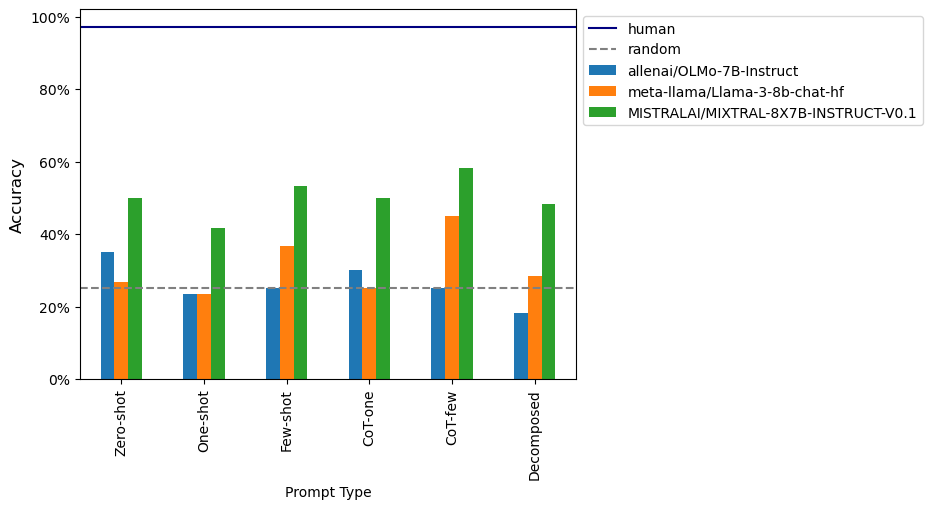

In [33]:
multi_pv = results_df[results_df['Question type']=='multi'].pivot_table(index='Model', columns='Prompt Type', values='Eval', aggfunc='mean').loc[models, prompts]
display(multi_pv)
helpers.plot_results(multi_pv, type='multi', radnom_line=0.25) # for now the lines are not really correct

# Yes\No results

Prompt Type,zero_shot,one_shot,few_shot,CoT-one,CoT-few,decomposite
Model,,,,,,
allenai/OLMo-7B-Instruct,0.500000,0.500000,0.516667,0.508333,0.525000,0.491667
meta-llama/Llama-3-8b-chat-hf,0.491667,0.558333,0.575000,0.575000,0.616667,0.516667
MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1,0.591667,0.758333,0.558333,0.608333,0.550000,0.725000


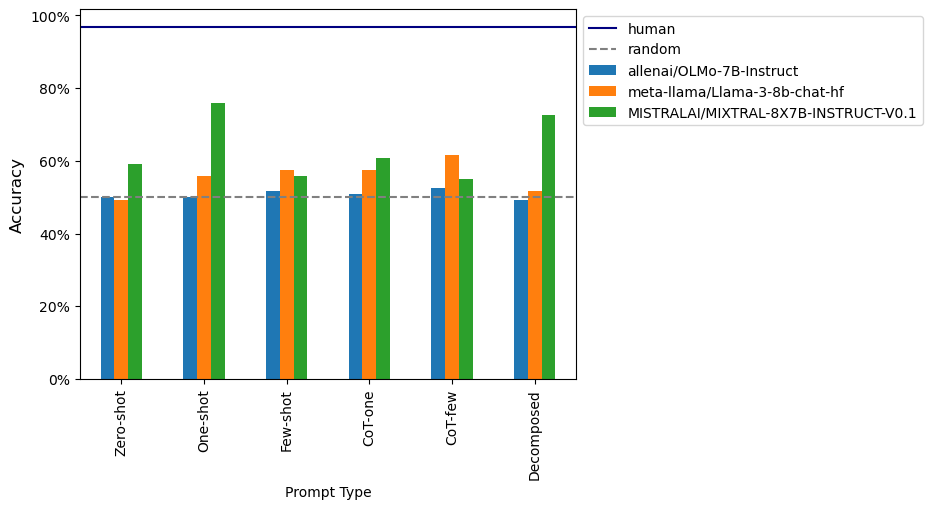

In [34]:
classification_pv = results_df[results_df['Question type']=='classification'].pivot_table(index='Model', columns='Prompt Type', values='Eval', aggfunc='mean').loc[models, prompts]
display(classification_pv)
helpers.plot_results(classification_pv, type='classification', radnom_line=0.5) # for now the lines are not really correct